### Source : https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

#### Leveraging BERT and TF-IDF to create topic model.
Pre-trained transformer-based models are especially helpful as they are supposed to contain more accurate representations of words and sentences.

##### Dataset
Load the filenames and data from the 20 newsgroups dataset (classification).

- Classes:20
- Samples total:18846
- Dimensionality:1
- Features:text

In [ ]:
!pip install scikit-learn

In [23]:
%%time
from sklearn.datasets import fetch_20newsgroups

# Downloaded and cached so that it's not downloaded every time
data = fetch_20newsgroups(subset='train')['data']


Wall time: 240 ms


In [20]:
print('Type: ', type(data))
print('Number of data points', len(data))
print('Value type:', type(data[0]))
print('\nSample data point \n',data[0])

Type:  <class 'list'>
Number of data points 18846
Value type: <class 'str'>

Sample data point 
 From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!





- ToDo: Only use mail content for topic modelling

##### Create Embeddings
The very first step we have to do is converting the documents to numerical data. We use BERT for this purpose as it extracts different embeddings based on the context of the word.

For this, we are using SentenceTransformers - a Python framework for state-of-the-art sentence and text embeddings.
https://www.sbert.net/

This framework provides an easy method to compute dense vector representations for sentences and paragraphs (also known as sentence embeddings). The models are based on transformer networks like BERT / RoBERTa / XLM-RoBERTa etc. and are tuned specificially meaningul sentence embeddings such that sentences with similar meanings are close in vector space.

In [26]:
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

!pip install sentence-transformers

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1


In [29]:
%%time
from sentence_transformers import SentenceTransformer
# DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. 
# It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances.
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

In [32]:
for sentence, embedding in zip(data[:1], embeddings[:1]):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Embedding: [-5.84846079e-01 -4.69497025e-01  4.10436064e-01 -7.23155558e-01
 -6.02805614e-01 -2.39600644e-01  4.06492829e-01 -4.50898767e-01
  2.97268629e-01  7.85825789e-01  8.79602253e-01  3.16943049e-01
  2.56070554e-01  3.74308348e-01  3.94643843e-02 -5.00394940e-

##### UMAP
Before doing any clustering of documents, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly, for which we use UMAP (https://github.com/lmcinnes/umap). Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data:

- The data is uniformly distributed on a Riemannian manifold;
- The Riemannian metric is locally constant (or can be approximated as such);
- The manifold is locally connected.

We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15

In [37]:
!pip install umap-learn

In [41]:
%%time
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-win_amd64.whl size=618176 sha256=99db8da43eb74c760cd01263e8f6e4d00f1bc2131ff2f6e60da1ee84cbbfd851
  Stored in directory: c:\users\install_1407\appdata\local\pip\cache\wheels\36\20\d1\521b2fbf637de5bc40668b6445944e7e44bfbe68fdaa65157d
Successfully built hdbscan
Wall time: 12.7 s


##### Clustering using HDBSCAN
We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. 
For this we use HDBSCAN, which is a suite of tools to use unsupervised learning to find clusters, or dense regions, of a dataset.
https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html

    

In [40]:
!pip install hdbscan

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'


In [42]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [49]:
print('Number of clusters created: ', cluster.labels_.max()+1)

Number of clusters created:  69


##### Visualization of clusters

First reduce the dim. to 2 and visualize the outliers (label = -1) as gray points.

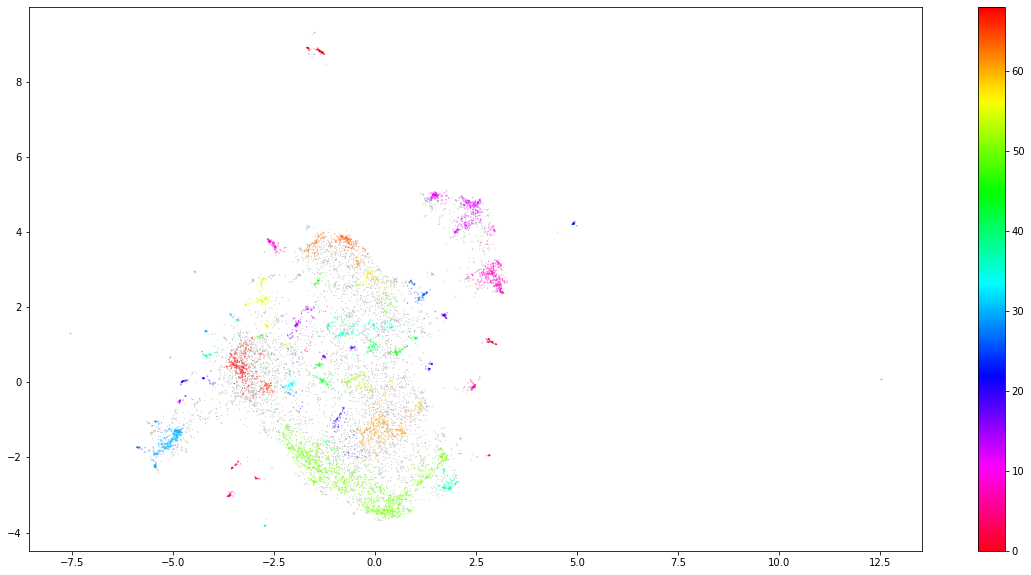

In [45]:
import matplotlib.pyplot as plt
import pandas as pd 

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

##### Create Topics
What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another? 

For this we use a class-based variant of TF-IDF (c-TF-IDF), that would allow t extract what makes each set of documents unique compared to the other.

The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.


What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

In [47]:
# To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [51]:
docs_df.head()

,Doc,Topic,Doc_ID
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,50,0
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,-1,1
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,-1,2
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,68,3
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,-1,4


In [53]:
docs_per_topic.head()
# -1 are the outliers

,Topic,Doc
0,-1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
1,0,From: sera@zuma.UUCP (Serdar Argic)\nSubject: ...
2,1,From: oz@ursa.sis.yorku.ca (Ozan S. Yigit)\nSu...
3,2,From: ifaz706@utxvms.cc.utexas.edu (Noam Tract...
4,3,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...


Apply c-tf-idf now

The frequency of each word t is extracted for each class i and divided by the total number of words w. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents m is divided by the total frequency of word t across all classes n.

In [55]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

Now, we have a single importance value for each word in a cluster which can be used to create the topic. If we take the top 20 most important words in each cluster based on their c-TF-IDF scores, then we would get a good representation of a cluster, and thereby a topic.The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [61]:
print('Shape of the TF-IDF output', tf_idf.shape)
# Number of words * number of clusters 
# The score tells the relative importance of every word in each cluster

Shape of the TF-IDF output (129796, 70)


In [65]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,5845
51,50,1312
9,8,334
31,30,293
62,61,277
13,12,274
69,68,248
65,64,139
38,37,123
37,36,119


We can see that topics 50, 8, 30, 61 are the largest clusters that we could create (-1 are outliers). To view the words belonging to those topics, we can simply use the dictionarytop_n_words to access these topics.

In [76]:
for topic in [50, 8, 30, 61]:
    print(f'Topic {topic}\n', top_n_words[topic][:10], '\n')

Topic 50
 [('sale', 0.008889929630668869), ('00', 0.007259391673408139), ('thanks', 0.005844150249268806), ('car', 0.00580942871054605), ('dos', 0.005571546859844802), ('windows', 0.005275491232088138), ('price', 0.004824997440522813), ('cx', 0.004794182266861812), ('c_', 0.004374954816803188), ('card', 0.004281002649596861)] 

Topic 8
 [('baseball', 0.016536041931904215), ('players', 0.011835529189980156), ('braves', 0.011257882121194156), ('cubs', 0.011081924816131593), ('game', 0.010464815515045507), ('pitching', 0.009993521485975812), ('02', 0.009719514464417366), ('games', 0.00959203291183319), ('runs', 0.009423074837877896), ('phillies', 0.00939764295081709)] 

Topic 30
 [('nasa', 0.02943029536732928), ('space', 0.022751512940185483), ('gov', 0.017871743344432017), ('launch', 0.013408604320286855), ('jpl', 0.012154909248933556), ('satellite', 0.009254801158484609), ('spacecraft', 0.008638201998191031), ('station', 0.008619826462489863), ('baalke', 0.00797764397252848), ('shuttle'

##### Reducing the number of topics
There is a chance that, depending on the dataset, you will get hundreds of topics that were created! You can tweak the parameters of HDBSCAN such that you will get fewer topics through its min_cluster_size parameter but it does not allow you to 
specify the exact number of clusters.

To reduce the number of topics, we can use a compare the c-TF-IDF vectors among topics, merge the most similar ones, and finally re-calculate the c-TF-IDF vectors to update the representation of our topics.

In [78]:
# Take the least common topic and merged it with the most similar topic. 
# By repeating this 19 more times we reduced the number of topics.

from sklearn.metrics.pairwise import cosine_similarity
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
0,-1,5845
36,35,1457
7,6,353
43,42,311
24,23,310
11,10,274
49,48,270
27,26,140
46,45,139
39,38,129


In [80]:
for topic in topic_sizes['Topic'][1:5]:
    print(f'Topic {topic}\n', top_n_words[topic][:10], '\n')

Topic 35
 [('sale', 0.007742945553680112), ('00', 0.006258682621909829), ('car', 0.005650203571793135), ('thanks', 0.0054077973946940056), ('dos', 0.005058568548319985), ('windows', 0.005031914718393877), ('price', 0.004570777085270509), ('mail', 0.0041390097778088875), ('cx', 0.004075781865403664), ('keyboard', 0.003957685901873815)] 

Topic 6
 [('baseball', 0.015520189432353079), ('players', 0.011301073471579702), ('braves', 0.01056628084565541), ('cubs', 0.01040113306011984), ('game', 0.009920153748722687), ('pitching', 0.009379593206000927), ('02', 0.009194819307680105), ('runs', 0.009116319535538847), ('games', 0.009002769129763156), ('phillies', 0.008820321054755755)] 

Topic 42
 [('windows', 0.012754010962959441), ('problem', 0.010397365970515712), ('disk', 0.008996994189807097), ('allocation', 0.008895273711257805), ('dos', 0.0077905722496289095), ('drive', 0.007523727450338758), ('files', 0.007193823253550085), ('help', 0.006980998671239095), ('linked', 0.006970406651015213), 